In [471]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
import math
from IPython.display import display, Markdown
import torch
%matplotlib widget

## Lorenz equation

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

In [472]:
def lorenz_equation(xyz, sigma=10, p=38, beta=8 / 3):
    """calculation of the derivative of the lorenz equantion for one time step

    Args:
        xyz (np.array): input points of shape (n, 3) where n is the number of points
        sigma (int, optional): Defaults to 10.
        p (int, optional):  Defaults to 38.
        beta (float, optional): Defaults to 8/3.

    Returns:
        np.array: dx dy and dz for given points. Shape (n, 3)
    """
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]

    dx = sigma * (y - x)
    dy = x * (p - z) - y
    dz = x * y - beta * z

    return np.array([dx, dy, dz]).T


def create_lorenz_traj(start_points: np.array, n_steps: int, dt=0.01):
    """Calculate the points trajectory of the lorenz equation complimented with its derivatives by using Eulers method.

    Args:
        start_points (np.array): matrix of start_points with shape nx3
        n_steps (int): number of discrete timesteps
        dt (float, optional): time interval. Defaults to 0.01.

    Returns:
        tuple: returns a tuple of the trajectory points matrix of shape t+1xnx3 and the derivative matrix of txnx3
    """
    xyz = np.empty((n_steps + 1, start_points.shape[0], start_points.shape[1]))
    xyz[0] = start_points

    dxyz = np.empty((n_steps, start_points.shape[0], start_points.shape[1]))

    for i in range(n_steps):
        dt_xyz = lorenz_equation(xyz[i])
        dxyz[i] = dt_xyz
        xyz[i + 1] = xyz[i] + dt_xyz * dt

    return xyz[:-1], dxyz

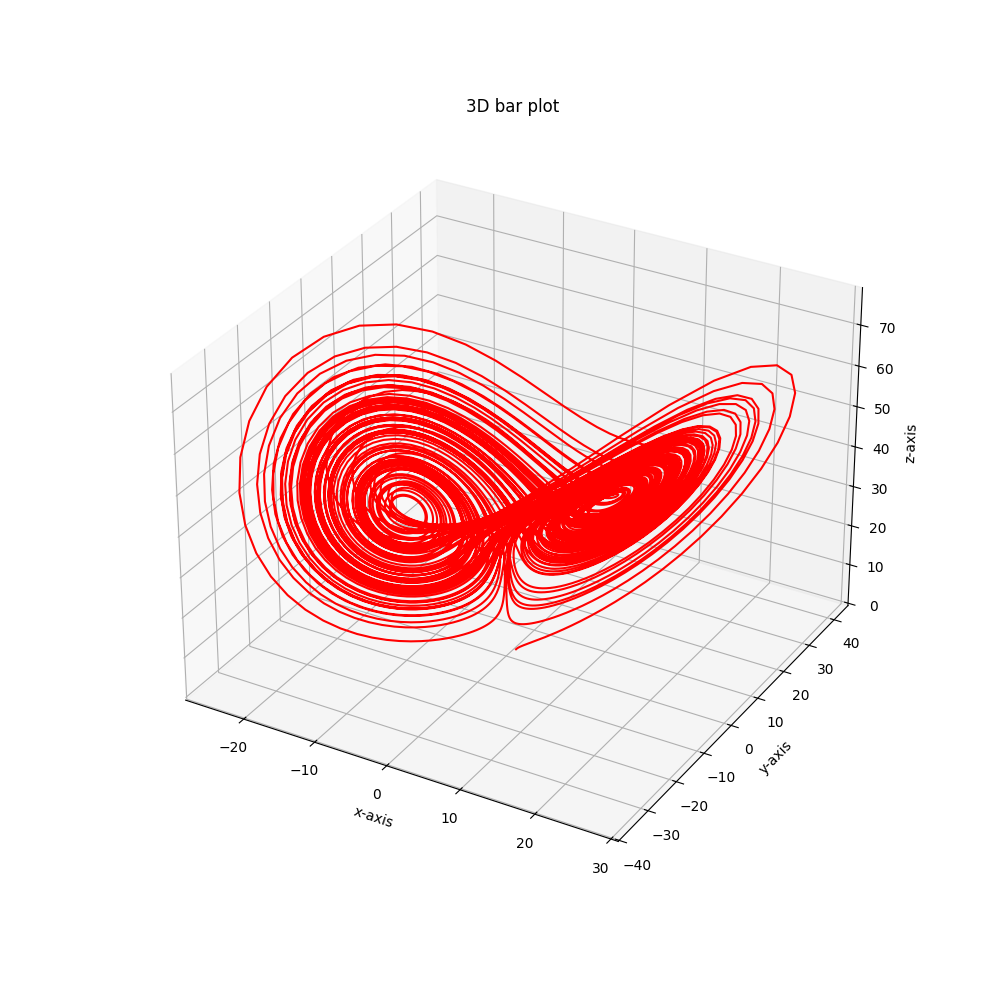

No such comm: 45e76bc652434aa4b5fc9f08b9aecfcf


In [510]:
n_steps = 10000
start_point = np.array([[1, 1, 1]])

xyz, _ = create_lorenz_traj(start_point, n_steps)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
line = ax.plot(xyz[:, 0, 0], xyz[:, 0, 1], xyz[:, 0, 2], color="r")[0]

ax.set_title("3D bar plot")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")


def animate(i):
    line.set_data_3d(xyz[:i, 0, :].T)  # update the data.
    line.set(alpha=0.5, color="r")
    return line


ani = FuncAnimation(fig, animate, n_steps, interval=10, repeat=True)

plt.show()

In [511]:
plt.close()

## Create dataset

In [513]:
n_steps = 1000
n_points = 1

start_points = np.random.uniform(low=-20, high=20, size=(n_points,3))

xyz, dxyz = create_lorenz_traj(start_points, n_steps)
xyz.shape, dxyz.shape

((1000, 1, 3), (1000, 1, 3))

## Feature expansion

In [514]:
# feature expansion

def calc_expansion_dim(degree: int, space_dim: int = 3):
    """Calculates the dimension after expansion

    Args:
        degree (int): max degree of the expansion
        space_dim (int, optional): The spatial dimension of the Differential equation (Lorenz equation has 3 dimensions). Defaults to 3.

    Returns:
        int: Size of the expanded dimension
    """
    dim = 1

    if degree >= 1:
        dim += space_dim

    if degree >= 2:
        for d in range(degree + 1)[2:]:
            dim += math.comb(space_dim + d - 1, d)

    return dim


def get_expansion_indices(exp_dim: int, space_dim: int):
    idx = [range(space_dim) for _ in range(exp_dim)]

    idx = np.array(np.meshgrid(*idx)).T.reshape(-1, exp_dim).tolist()

    idx = np.unique([sorted(i) for i in idx], axis=0)

    return idx


def poly_expansion(X: np.array, max_deg=3):
    """A plynomial expansion of the input data up to max_exp

    Args:
        X (np.array): Trajectory data over time of shape txnx3 where t is the number of timesteps and n the number of start points
        max_deg (int, optional): Degree of the maximum expansion. Defaults to 3.

    Returns:
        np.array: The polynomial expanded input matrix of shape ...
    """
    t, n, _ = X.shape  # (time, #samples, 3)

    X_poly = np.empty((t, n, calc_expansion_dim(max_deg)))

    X_poly[:, :, 0] = 1
    X_poly[:, :, 1:4] = X

    idx = [[-1],[0],[1],[2]]

    if max_deg >= 2:
        col_idx = 4
        for d in range(max_deg+1)[2:]:
            #print(d)
            comb_idx = get_expansion_indices(d, 3)
            idx += comb_idx.tolist()
            len_exp = len(comb_idx)

            products = np.stack([np.prod([X[:, :, i] for i in indices], axis=0) for indices in comb_idx], axis=-1)

            X_poly[:, :, col_idx : col_idx + len_exp] = products
            col_idx += len_exp

    return X_poly, idx

In [515]:
X_poly, idx = poly_expansion(xyz, max_deg=3)
X_poly.shape, idx

((1000, 1, 20),
 [[-1],
  [0],
  [1],
  [2],
  [0, 0],
  [0, 1],
  [0, 2],
  [1, 1],
  [1, 2],
  [2, 2],
  [0, 0, 0],
  [0, 0, 1],
  [0, 0, 2],
  [0, 1, 1],
  [0, 1, 2],
  [0, 2, 2],
  [1, 1, 1],
  [1, 1, 2],
  [1, 2, 2],
  [2, 2, 2]])

## SINDy Model

In [534]:
class sindy_model(torch.nn.Module):
    def __init__(self, poly_dim: int, space_dim: int=3, sparsity_factor: float=1):
        super(sindy_model, self).__init__()
        self.linear = torch.nn.Linear(poly_dim, space_dim, bias=False)
        self.sparsity_factor = sparsity_factor

    def forward(self, X):
        # X = poly_X
        out = self.linear(X)
        return out
    
    def run(self, X):
        with torch.no_grad():
            out = self.linear(X).detach().numpy()
        return out
    
    # thetaX: t x p x poly_dim
    # X: t x p x dim
    # xi: poly_dim x #dim


# l2 + l1
def lasso(model: sindy_model, model_out: torch.tensor, gt: torch.tensor):
    # t x p x #params
    # get three losses

    model_param = list(model.parameters())

    l2 = torch.sqrt(torch.sum((model_out - gt)**2))
    l1 = model.sparsity_factor * torch.sum(torch.abs(model_param[0]))

    return l2 + l1, l2

In [535]:
def train(model: torch.nn.Module, X: torch.tensor, gt: torch.tensor, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        out = model(X)

        loss, l2 = lasso(model, out, gt)
        #print(f"{epoch}: {loss},{l2}")
        losses.append(l2.item())

        loss.backward()

        optimizer.step()

    return losses


In [536]:
model = sindy_model(X_poly.shape[-1], sparsity_factor=2)

X_in = torch.tensor(X_poly, dtype=torch.float32)
gt = torch.tensor(dxyz, dtype=torch.float32)

loss = train(model, X_in, gt, epochs=200)

In [537]:
def show_loss(loss: list):
    plt.clf()
    plt.plot(loss, label="loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

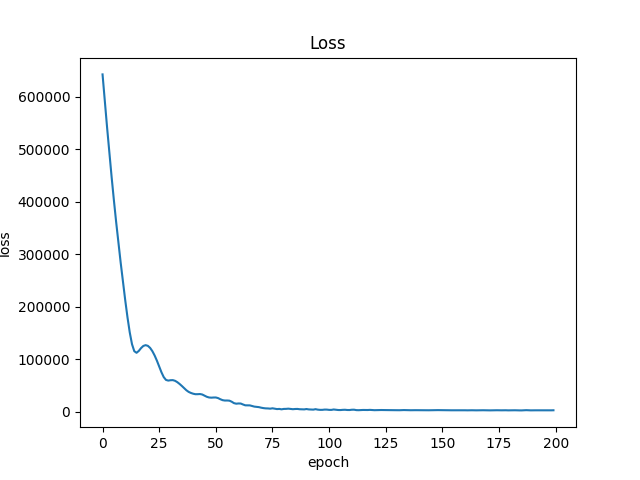

In [538]:
show_loss(loss)

In [539]:
def show_weigths(model: torch.nn.Module, idx: list, dims=["x","y","z"]):
    params = list(model.parameters())[0].detach().numpy()

    nonzeros = ~np.isclose(params, np.zeros_like(params), atol=.1)

    params = (params * nonzeros).T.tolist()

    dims += ["1"]

    table_string = "| |"

    table_string += "".join([f" d{d} |" for d in dims[:-1]])
    table_string += "\n"
    table_string += "|:----|" + "".join(["-----:|" for _ in range(len(dims[:-1]))]) + "\n"
    
    for row, indices in zip(params, idx):
        exp_term = "".join([dims[i] for i in indices])

        table_string += f"| {exp_term} | " + " | ".join([f"{round(el,3)}" if el == 0 else f"<span style='color:red;'>{round(el,3)}</span>" for el in row]) + " | \n"
        
    display(Markdown(table_string))

In [540]:
show_weigths(model, idx)

| | dx | dy | dz |
|:----|-----:|-----:|-----:|
| 1 | -0.0 | 0.0 | -0.0 | 
| x | 0.0 | <span style='color:red;'>0.556</span> | 0.0 | 
| y | <span style='color:red;'>0.279</span> | <span style='color:red;'>0.99</span> | <span style='color:red;'>-0.456</span> | 
| z | 0.0 | <span style='color:red;'>0.179</span> | -0.0 | 
| xx | -0.0 | -0.0 | -0.0 | 
| xy | 0.0 | <span style='color:red;'>0.294</span> | <span style='color:red;'>0.202</span> | 
| xz | <span style='color:red;'>0.218</span> | 0.0 | 0.0 | 
| yy | -0.0 | <span style='color:red;'>-0.116</span> | <span style='color:red;'>0.185</span> | 
| yz | -0.0 | <span style='color:red;'>0.453</span> | -0.0 | 
| zz | 0.0 | -0.0 | -0.0 | 
| xxx | 0.0 | -0.0 | 0.0 | 
| xxy | -0.0 | 0.0 | -0.0 | 
| xxz | 0.0 | -0.0 | 0.0 | 
| xyy | 0.0 | -0.0 | 0.0 | 
| xyz | -0.0 | 0.0 | 0.0 | 
| xzz | -0.0 | -0.0 | -0.0 | 
| yyy | -0.0 | 0.0 | -0.0 | 
| yyz | 0.0 | 0.0 | -0.0 | 
| yzz | 0.0 | -0.0 | 0.0 | 
| zzz | -0.0 | 0.0 | -0.0 | 


In [532]:
out = model.run(X_in)
out.shape, xyz.shape, dxyz.shape

((1000, 1, 3), (1000, 1, 3), (1000, 1, 3))

(1000,)


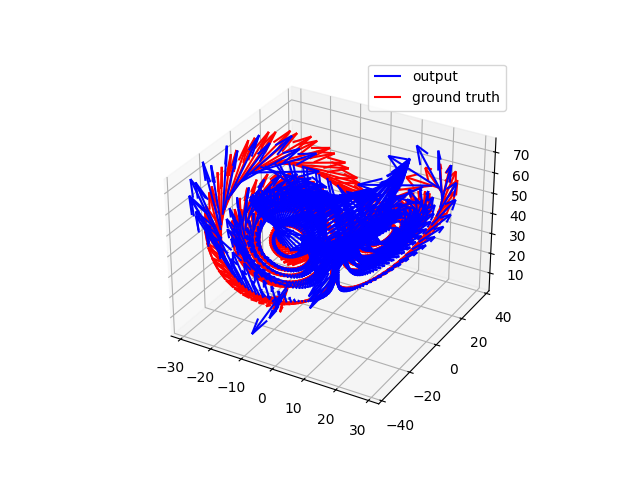

In [533]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

x = xyz[:,:,0].squeeze()
y = xyz[:,:,1].squeeze()
z = xyz[:,:,2].squeeze()

dx_out = out[:,:,0].squeeze()
dy_out = out[:,:,1].squeeze()
dz_out = out[:,:,2].squeeze()

dx_gt = dxyz[:,:,0].squeeze()
dy_gt = dxyz[:,:,1].squeeze()
dz_gt = dxyz[:,:,2].squeeze()

print(dx_out.shape)


ax.quiver(x, y, z, dx_out, dy_out, dz_out, length=.05, color="blue", label="output")
ax.quiver(x, y, z, dx_gt, dy_gt, dz_gt, length=.05, color="red", label="ground truth")

ax.set_xbound(x.min()-10,x.max()+10)
ax.set_ybound(y.min()-10,y.max()+10)
ax.set_zbound(z.min()-10,z.max()+10)

plt.legend()

In [525]:
plt.close()